# Music Through the Decades

### Intro 
As I'm typing this introduction, I'm bopping to "Holiday" by Green Day, on a random "Pump Up Music" playlist that I found 5 minutes ago (thank you apache_king!). Music has played and continues to play a very important part of my life. I've been jamming to something or the other since first grade, learned to play the guitar in second grade, and have been in every band I possibly could throughout elementary, middle, and high school. Ever since starting college, I've gone to over 10 different concerts, and much to my roommates' consternation, every time I shower I blare anything from Imagine Dragons to Logic to Linkin Park to Queen (and badly sing to it). 

Needless to say, music is important to me. It's how I process my emotions when I'm upset, motivate myself when I feel lazy, and run the extra 3 minutes (because running the extra mile is too much to ask for) when I'm sweating it out at the gym. I'm sure I'm not the only one like this either. The emotions of a generation are forever captured by the popularity of songs of that time. Music has come to define eras and decades, like the psychedlic rock of the Beatles dominating the 60s, the eccentric theatric rock of Queen of the 80s, and even artists like NSYNC coming to embody the odd time that was the 90s. 

### Goals of the Project
We thought it would be interesting to see if there were changes between the popular music of the decades from the 50s through the 2010s. With every generation facing a different landscape, from the post-war economic boom in the 50s to recession in the late 2000s, we thought it would be interesting to explore whether changes in music reflected that. Would the uncertainty of a war with Russia in the 80s drive people to seek out more angry or sad music? Would the happiness after the end of World War 2 be reflected in the popularity of the songs in that era? By that token, by analyzing the popular songs of these decades, can we build a classifier that could predict the era a song was created in based off of its audio features? 

### How We Will Do This
Using Spotify and Genius's Web APIs, we wanted to explore these questions and present a case study in the changes in popular music over the decades. We will use Spotify's own "All Out" playlists, which are organized by decade. We felt that these playlists would prove a promising source of information about the popular songs of a certain decade. We will use Spotify's API to be able to gain information about the features of the track, from danceability to 'speechiness'. 

## Step One : Imports
The first thing we did was import everything that we needed. Because we were accessing the Spotify and Genius APIs, we use the requests library as well as others to be able to parse the information we query into a dataframe. There is a spotify library for python called spotipy, but we realized that there was not huge benefit from using that library instead of just using requests and get calls to the API endpoint. We will also later use the Natural Language ToolKit (or NLTK) to meaningfully analyze text, so we download the necessary modules from within that as well. Lastly, for preliminary machine learning, we also imported different modules within SciKit-Learn. 


In [32]:
# Request / Parsing 
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize
import string

#Visualization and EDA 
import sys 
# The below 3 statements were only done because we were coding within a Jupyter notebook set up for our class (CMSC320). 
# For those following at home, you will likely just need to pip install these in your command-line, instead of within 
# the confines of the notebook itself. 

!{sys.executable} -m pip install Pillow  
!{sys.executable} -m pip install wordcloud
!{sys.executable} -m pip install -U nltk
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
import seaborn as sns

#Machine Learning 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

from sklearn import preprocessing
from sklearn import metrics

You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: nltk in /opt/conda/lib/python3.6/site-packages
Requirement already up-to-date: six in /opt/conda/lib/python3.6/site-packages (from nltk)
Requirement already up-to-date: singledispatch in /opt/conda/lib/python3.6/site-packages (from nltk)
You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## STEP 2: Gaining Access to the Spotify and Genius Web APIs 
To be able to continue with this project, you need authentification tokens provided through Spotify. We would periodically request tokens from this website : https://developer.spotify.com/console/get-playlist-tracks/?playlist_id=37i9dQZF1DX5Ejj0EkURtP&market=&fields=&limit=&offset= to query Spotify. This requires a Spotify account. Similarly, Genius's API requires an account as well. We used this website: https://docs.genius.com/#/getting-started-h1 to set up our own accounts. 

Afterwards, store the tokens within variables. 

In [2]:
# https://developer.spotify.com/console/get-playlist-tracks/?playlist_id=37i9dQZF1DX5Ejj0EkURtP&market=&fields=&limit=&offset= 
# use above website to generate token
token = "BQByHlUq7rYFTmMjyQyo6AuLP9YVddXobQ7Ct0ynaOFuBO6TBfWckTG-dypBNZrymZtDKiO8h0lLfJ1hPnDWr_bP_zgTyfFbOgok8fEf_5BGsZmyxrcHvt6GO8dabwDabPKLcCbJUtI_HH96_Q"
# https://genius.com/api-clients ==> use this website to generate token
genius_token = 'V3BxSvKtWKcSlonUDfqeKWZmRKK3qjGyAGJCRqxm8awvuWI65nm7WFrYmnn3acIu'

# token = "INSERT SPOTIFY TOKEN HERE"
# genius_token = "INSERT GENIUS TOKEN HERE"

## STEP 3: Getting the Information Into a Dataframe
We used two different endpoints to get the necessary data to analyze the trends over time. The first one was to grab the decades playlist provided by Spotify from the 50s to the 2010s. These playlists list the most popular songs of the decade.

In [3]:
r_10s = requests.get("https://api.spotify.com/v1/playlists/37i9dQZF1DX5Ejj0EkURtP", headers={'Authorization': 'Bearer ' + token})
r_00s = requests.get("https://api.spotify.com/v1/playlists/37i9dQZF1DX4o1oenSJRJd", headers={'Authorization': 'Bearer ' + token})
r_90s = requests.get("https://api.spotify.com/v1/playlists/37i9dQZF1DXbTxeAdrVG2l", headers={'Authorization': 'Bearer ' + token})
r_80s = requests.get("https://api.spotify.com/v1/playlists/37i9dQZF1DX4UtSsGT1Sbe", headers={'Authorization': 'Bearer ' + token})
r_70s = requests.get("https://api.spotify.com/v1/playlists/37i9dQZF1DWTJ7xPn4vNaz", headers={'Authorization': 'Bearer ' + token})
r_60s = requests.get("https://api.spotify.com/v1/playlists/37i9dQZF1DXaKIA8E7WcJj", headers={'Authorization': 'Bearer ' + token})
r_50s = requests.get("https://api.spotify.com/v1/playlists/37i9dQZF1DWSV3Tk4GO2fq", headers={'Authorization': 'Bearer ' + token})


### Parsing the Data
We had to get the data into a form that is more readily understandable. The data returned from the playlist endpoint is in JSON format and many important data points very nested inside the JSON object. The code below is grabbing the important data from the JSON returned from each call to the API, grabbing those nested data points as well, and converting it into multiple dataframes. This shows the results for the 2010s playlist. We then replicated it for all of the other decades.

In [4]:
json_data = r_10s.json()
playlists_10 = json_normalize(json_data["tracks"]["items"], [['track', 'artists']], ['added_at', ['track', 'popularity'], ['track', 'id'], ['track', 'name'], ['track', 'duration_ms']], errors='ignore')
playlists_10 = playlists_10.drop(columns=['external_urls', 'href', 'type', 'uri'])

playlists_10

,id,name,added_at,track.popularity,track.id,track.name,track.duration_ms
0,4UXqAaa6dQYAk18Lv7PEgX,Fall Out Boy,2018-12-01T17:58:03Z,62,3x7NGlfDKQYN2wnwEnL7r9,The Kids Aren't Alright,260920
1,3NPpFNZtSTHheNBaWC82rB,X Ambassadors,2018-12-01T17:58:03Z,75,7lGKEWMXVWWTt3X71Bv44I,Unsteady,193546
2,10exVja0key0uqUkk6LJRT,Vance Joy,2018-12-01T17:58:03Z,56,7lrDNvF3TwuC5vC2fGiMjy,Mess Is Mine,223640
3,4BxCuXFJrSWGi1KHcVqaU4,Kodaline,2018-12-01T17:58:03Z,68,2PwXOevGUSkU8qaYZjgLq2,All I Want,305746
4,246dkjvS1zLTtiykXe5h60,Post Malone,2018-12-01T17:58:03Z,86,75ZvA4QfFiZvzhj2xkaWAh,I Fall Apart,223346
5,536BYVgOnRky0xjsPT96zl,Two Door Cinema Club,2018-12-01T17:58:03Z,68,1qfYG2JrchEyJiqKnkE7YQ,What You Know,189693
6,2WzaAvm2bBCf4pEhyuDgCY,Ruth B.,2018-12-01T17:58:03Z,76,4h0zU3O9R5xzuTmNO7dNDU,Lost Boy,275280
7,10exVja0key0uqUkk6LJRT,Vance Joy,2018-12-01T17:58:03Z,28,6uEIbSu5Omm6Rg2hcVrfJH,Georgia,230506
8,4BxCuXFJrSWGi1KHcVqaU4,Kodaline,2018-12-01T17:58:03Z,69,7jDe24vXWUNX8Jl2hZHrIS,High Hopes,230266
9,36jaGQtMj5UWD0eO1fCVdD,Joel Adams,2018-12-01T17:58:03Z,76,3cNjgVBKTJ1SvKhunrCdVy,Please Don't Go,210580


In [5]:
json_data = r_10s.json()
playlists_10 = json_normalize(json_data["tracks"]["items"], [['track', 'artists']], ['added_at', ['track', 'popularity'], ['track', 'id'], ['track', 'name'], ['track', 'duration_ms']], errors='ignore')
playlists_10 = playlists_10.drop(columns=['external_urls', 'href', 'type', 'uri'])

json_data_00 = r_00s.json()
playlists_00 = json_normalize(json_data_00["tracks"]["items"], [['track', 'artists']], ['added_at', ['track', 'popularity'], ['track', 'id'], ['track', 'name'], ['track', 'duration_ms']], errors='ignore')
playlists_00 = playlists_00.drop(columns=['external_urls', 'href', 'type', 'uri'])

json_data_90 = r_90s.json()
playlists_90 = json_normalize(json_data_90["tracks"]["items"], [['track', 'artists']], ['added_at', ['track', 'popularity'], ['track', 'id'], ['track', 'name'], ['track', 'duration_ms']], errors='ignore')
playlists_90 = playlists_90.drop(columns=['external_urls', 'href', 'type', 'uri'])

json_data_80 = r_80s.json()
playlists_80 = json_normalize(json_data_80["tracks"]["items"], [['track', 'artists']], ['added_at', ['track', 'popularity'], ['track', 'id'], ['track', 'name'], ['track', 'duration_ms']], errors='ignore')
playlists_80 = playlists_80.drop(columns=['external_urls', 'href', 'type', 'uri'])

json_data_70 = r_70s.json()
playlists_70 = json_normalize(json_data_70["tracks"]["items"], [['track', 'artists']], ['added_at', ['track', 'popularity'], ['track', 'id'], ['track', 'name'], ['track', 'duration_ms']], errors='ignore')
playlists_70 = playlists_70.drop(columns=['external_urls', 'href', 'type', 'uri'])

json_data_60 = r_60s.json()
playlists_60 = json_normalize(json_data_60["tracks"]["items"], [['track', 'artists']], ['added_at', ['track', 'popularity'], ['track', 'id'], ['track', 'name'], ['track', 'duration_ms']], errors='ignore')
playlists_60 = playlists_60.drop(columns=['external_urls', 'href', 'type', 'uri'])

json_data_50 = r_50s.json()
playlists_50 = json_normalize(json_data_50["tracks"]["items"], [['track', 'artists']], ['added_at', ['track', 'popularity'], ['track', 'id'], ['track', 'name'], ['track', 'duration_ms']], errors='ignore')
playlists_50 = playlists_50.drop(columns=['external_urls', 'href', 'type', 'uri'])

playlists_80

,id,name,added_at,track.popularity,track.id,track.name,track.duration_ms
0,0PFtn5NtBbbUNbU9EAmIWF,Toto,2018-12-01T18:05:10Z,66,5tJjo5JDF9zhzYD7yQfATH,Africa,296000
1,4QTVePrFu1xuGM9K0kNXkk,Dexys Midnight Runners,2018-12-01T18:05:10Z,28,5uzNa0SBGOe5pPnstWHMCt,Come On Eileen,273720
2,77tT1kLj6mCWtFNqiOmP9H,Daryl Hall & John Oates,2018-12-01T18:05:10Z,76,4o6BgsqLIBViaGVbx5rbRk,You Make My Dreams,190626
3,6zFYqv1mOsgBRQbae3JJ9e,Billy Joel,2018-12-01T18:05:10Z,74,5zA8vzDGqPl2AzZkEYQGKh,Uptown Girl,197706
4,4bthk9UfsYUYdcFyqxmSUU,Tears For Fears,2018-12-01T18:05:10Z,78,4RvWPyQ5RL0ao9LPZeSouE,Everybody Wants To Rule The World,251488
5,6IFXsrXBpwbIqtOUOiAa3p,Rick Springfield,2018-12-01T18:05:10Z,60,2F1fnE1a8zQCogM6jJifHH,Jessie's Girl,194266
6,3RGLhK1IP9jnYFH4BRFJBS,The Clash,2018-12-01T18:05:10Z,76,39shmbIHICJ2Wxnk1fPSdz,Should I Stay or Should I Go - Remastered,188986
7,77tT1kLj6mCWtFNqiOmP9H,Daryl Hall & John Oates,2018-12-01T18:05:10Z,60,5HQ639Z3ms3hnZx0KfWnkp,Private Eyes - Remastered,217200
8,0rvjqX7ttXeg3mTy8Xscbt,Journey,2018-12-01T18:05:10Z,67,71SvEDmsOwIWw1IozsZoMA,Any Way You Want It,201693
9,2jzc5TC5TVFLXQlBNiIUzE,a-ha,2018-12-01T18:05:10Z,81,2WfaOiMkCvy7F5fcp2zZ8L,Take On Me,225280


### Getting the Music Attributes
Now that we have the information about each playlist, we want to grab information for each track inside the playlists. The code below makes a list of all the track ids in the playlists and uses that to call to the second end point we use: the audio features end point. This end point will give a good amount of information such, the valence, the tempo, the danceability, the instrumentalness, the speechiness, and the energy of each of the songs in the playlist and convert it into a dataframe. However, this endpoint will also give us unnecessary information such as the mode, track_href, uri, and analysis url of the song, which is not useful for our analysis. 

In [6]:
aggregation_functions = {'name': 'first', 'track.id': 'first', 'track.duration_ms': 'first', 'added_at': 'first', 'track.popularity' : 'first'}
df_new = playlists_10.groupby(playlists_10['track.name']).aggregate(aggregation_functions)

aggregation_functions = {'name': 'first', 'track.id': 'first', 'track.duration_ms': 'first', 'added_at': 'first', 'track.popularity' : 'first'}
grouped_00 = playlists_00.groupby(playlists_00['track.name']).aggregate(aggregation_functions)

aggregation_functions = {'name': 'first', 'track.id': 'first', 'track.duration_ms': 'first', 'added_at': 'first', 'track.popularity' : 'first'}
grouped_90 = playlists_90.groupby(playlists_90['track.name']).aggregate(aggregation_functions)

aggregation_functions = {'name': 'first', 'track.id': 'first', 'track.duration_ms': 'first', 'added_at': 'first', 'track.popularity' : 'first'}
grouped_80 = playlists_80.groupby(playlists_80['track.name']).aggregate(aggregation_functions)

aggregation_functions = {'name': 'first', 'track.id': 'first', 'track.duration_ms': 'first', 'added_at': 'first', 'track.popularity' : 'first'}
grouped_70 = playlists_70.groupby(playlists_70['track.name']).aggregate(aggregation_functions)

aggregation_functions = {'name': 'first', 'track.id': 'first', 'track.duration_ms': 'first', 'added_at': 'first', 'track.popularity' : 'first'}
grouped_60 = playlists_60.groupby(playlists_60['track.name']).aggregate(aggregation_functions)

aggregation_functions = {'name': 'first', 'track.id': 'first', 'track.duration_ms': 'first', 'added_at': 'first', 'track.popularity' : 'first'}
grouped_50 = playlists_50.groupby(playlists_50['track.name']).aggregate(aggregation_functions)


In [7]:
track_ids = df_new['track.id'].tolist()
track_str = '%2C'.join(track_ids)
t = requests.get("https://api.spotify.com/v1/audio-features?ids=" + track_str, headers={'Authorization': 'Bearer ' + token})
track_info_df = json_normalize(t.json()['audio_features'])
track_info_df = track_info_df.drop(columns=['analysis_url', 'mode', 'track_href', 'type', 'uri'])

track_ids_00 = grouped_00['track.id'].tolist()
track_str_00 = '%2C'.join(track_ids_00)
t_00s = requests.get("https://api.spotify.com/v1/audio-features?ids=" + track_str_00, headers={'Authorization': 'Bearer ' + token})
track_info_00 = json_normalize(t_00s.json()['audio_features'])
track_info_00 = track_info_00.drop(columns=['analysis_url', 'mode', 'track_href', 'type', 'uri'])

track_ids_90 = grouped_90['track.id'].tolist()
track_str_90 = '%2C'.join(track_ids_90)
t_90s = requests.get("https://api.spotify.com/v1/audio-features?ids=" + track_str_90, headers={'Authorization': 'Bearer ' + token})
track_info_90 = json_normalize(t_90s.json()['audio_features'])
track_info_90 = track_info_90.drop(columns=['analysis_url', 'mode', 'track_href', 'type', 'uri'])

track_ids_80 = grouped_80['track.id'].tolist()
track_str_80 = '%2C'.join(track_ids_80)
t_80s = requests.get("https://api.spotify.com/v1/audio-features?ids=" + track_str_80, headers={'Authorization': 'Bearer ' + token})
track_info_80 = json_normalize(t_80s.json()['audio_features'])
track_info_80 = track_info_80.drop(columns=['analysis_url', 'mode', 'track_href', 'type', 'uri'])

track_ids_70 = grouped_70['track.id'].tolist()
track_str_70 = '%2C'.join(track_ids_70)
t_70s = requests.get("https://api.spotify.com/v1/audio-features?ids=" + track_str_70, headers={'Authorization': 'Bearer ' + token})
track_info_70 = json_normalize(t_70s.json()['audio_features'])
track_info_70 = track_info_70.drop(columns=['analysis_url', 'mode', 'track_href', 'type', 'uri'])

track_ids_60 = grouped_60['track.id'].tolist()
track_str_60 = '%2C'.join(track_ids_60)
t_60s = requests.get("https://api.spotify.com/v1/audio-features?ids=" + track_str_60, headers={'Authorization': 'Bearer ' + token})
track_info_60 = json_normalize(t_60s.json()['audio_features'])
track_info_60 = track_info_60.drop(columns=['analysis_url', 'mode', 'track_href', 'type', 'uri'])

track_ids_50 = grouped_50['track.id'].tolist()
track_str_50 = '%2C'.join(track_ids_50)
t_50s = requests.get("https://api.spotify.com/v1/audio-features?ids=" + track_str_50, headers={'Authorization': 'Bearer ' + token})
track_info_50 = json_normalize(t_50s.json()['audio_features'])
track_info_50 = track_info_50.drop(columns=['analysis_url', 'mode', 'track_href', 'type', 'uri'])

#track.name appears to be in the index so we need to reindex it
grouped_50_index = grouped_50.index
grouped_50.index = range(len(grouped_50))
grouped_50["track.name"] = grouped_50_index

grouped_60_index = grouped_60.index
grouped_60.index = range(len(grouped_60))
grouped_60["track.name"] = grouped_60_index

grouped_70_index = grouped_70.index
grouped_70.index = range(len(grouped_70))
grouped_70["track.name"] = grouped_70_index

grouped_80_index = grouped_80.index
grouped_80.index = range(len(grouped_80))
grouped_80["track.name"] = grouped_80_index

grouped_90_index = grouped_90.index
grouped_90.index = range(len(grouped_90))
grouped_90["track.name"] = grouped_90_index

grouped_00_index = grouped_00.index
grouped_00.index = range(len(grouped_00))
grouped_00["track.name"] = grouped_00_index

df_index = df_new.index
df_new.index = range(len(df_new))
df_new["track.name"] = df_index

print(grouped_50)

                             name                track.id  track.duration_ms  \
0         Bill Haley & His Comets  5PZf7EZr7GfkOAgeEcsqPa             134106   
1             Dion & The Belmonts  6AhHYWJOBMRjEi2z1tWpYa             153866   
2                     Fats Domino  4ZfQwNx3FlCN07cnUvekh3             152200   
3             Danny & The Juniors  6vkuJbGjyjnSQReeaCh8wT             149933   
4                     The Regents  0Aoh3SQxGdBlxVSXLZUToj             135773   
5    Gene Vincent & His Blue Caps  0TMrV95mP7sDlvbE4iVfKP             157206   
6                     Fats Domino  2NkAoxQOr6MGdMB5JDTU81             143440   
7                   The Monotones  6kIYy84YuKk2dwAZbYJjrG             138986   
8                     Louis Prima  7LYfx4uOewuMJnkAN4xHlj             180093   
9             The Everly Brothers  0xK34uEDBKa9ZzJ6kelLJE             142906   
10                  Eddie Cochran  3kEnKwF8IbvTwUuubZb17q             117666   
11                The Del-Vikings  4Ul2q

Now we have two groups of dataframes: the dataframes with each decade's playlist information, and the dataframes with all the song information for each decade. Now we want to merge the on a common columns between the two which would be the track id column.

In [ ]:
data_2010s = pd.merge(df_new, track_info_df, left_on = 'track.id', right_on = 'id')
data_2000s = pd.merge(grouped_00, track_info_00, left_on = 'track.id', right_on = 'id')
data_1990s = pd.merge(grouped_90, track_info_90, left_on = 'track.id', right_on = 'id')
data_1980s = pd.merge(grouped_80, track_info_80, left_on = 'track.id', right_on = 'id')
data_1970s = pd.merge(grouped_70, track_info_70, left_on = 'track.id', right_on = 'id')
data_1960s = pd.merge(grouped_60, track_info_60, left_on = 'track.id', right_on = 'id')
data_1950s = pd.merge(grouped_50, track_info_50, left_on = 'track.id', right_on = 'id')

We now want to add another column named decade to be able to differentiate between the different decades when we combine all dataframes into one large dataframe with all the information

In [9]:
data_2010s['decade'] = '2010s'
data_2000s['decade'] = '2000s'
data_1990s['decade'] = '1990s'
data_1980s['decade'] = '1980s'
data_1970s['decade'] = '1970s'
data_1960s['decade'] = '1960s'
data_1950s['decade'] = '1950s'

# In the code below, we combine all the dataframes into one large dataframe
decades_data = pd.concat([data_2010s, data_2000s, data_1990s, data_1980s, data_1970s, data_1960s, data_1950s])
decades_data['energy'].groupby(decades_data['decade']).describe()
# fixing the index
decades_data.index = range(len(decades_data))
decades_data.head()


### Some Exploratory Data Analysis
The following code gives a visualization of the trends in the different aspects of music using the averages in the large dataframe over the different audio features of the tracks.  

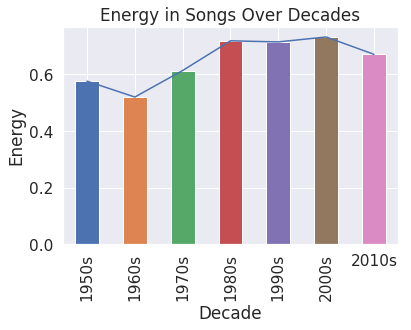

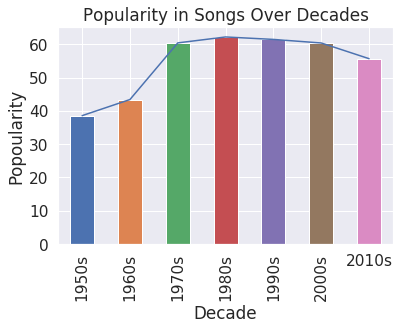

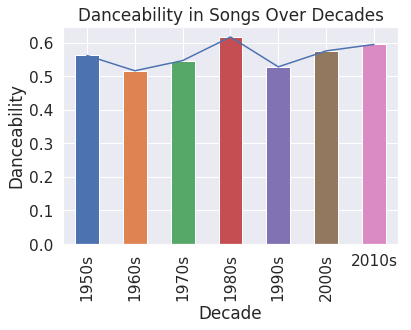

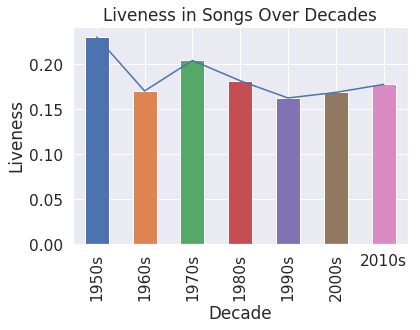

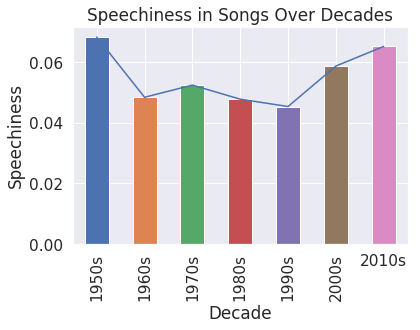

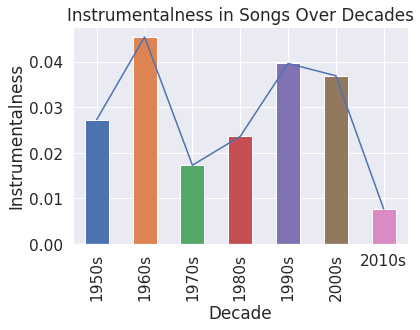

In [54]:
classes = ["1950s", "1960s", "1970s", "1980s", "1990s", "2000s", "2010s"]

decades_data['energy'].groupby(decades_data['decade']).mean().plot(kind='line')
decades_data['energy'].groupby(decades_data['decade']).mean().plot(kind='bar')
plt.ylabel('Energy')
plt.xlabel('Decade')
plt.title('Energy in Songs Over Decades')
plt.show()

decades_data['track.popularity'].groupby(decades_data['decade']).mean().plot(kind='line')
decades_data['track.popularity'].groupby(decades_data['decade']).mean().plot(kind='bar')
plt.ylabel('Popoularity')
plt.xlabel('Decade')
plt.title('Popularity in Songs Over Decades')
plt.show()

decades_data['danceability'].groupby(decades_data['decade']).mean().plot(kind='line')
decades_data['danceability'].groupby(decades_data['decade']).mean().plot(kind='bar')
plt.ylabel('Danceability')
plt.xlabel('Decade')
plt.title('Danceability in Songs Over Decades')
plt.show()

decades_data['liveness'].groupby(decades_data['decade']).mean().plot(kind='line')
decades_data['liveness'].groupby(decades_data['decade']).mean().plot(kind='bar')
plt.ylabel('Liveness')
plt.xlabel('Decade')
plt.title('Liveness in Songs Over Decades')
plt.show()

decades_data['speechiness'].groupby(decades_data['decade']).mean().plot(kind='line')
decades_data['speechiness'].groupby(decades_data['decade']).mean().plot(kind='bar')
plt.ylabel('Speechiness')
plt.xlabel('Decade')
plt.title('Speechiness in Songs Over Decades')
plt.show()

decades_data['instrumentalness'].groupby(decades_data['decade']).mean().plot(kind='line')
decades_data['instrumentalness'].groupby(decades_data['decade']).mean().plot(kind='bar')
plt.ylabel('Instrumentalness')
plt.xlabel('Decade')
plt.title('Instrumentalness in Songs Over Decades')
plt.show()


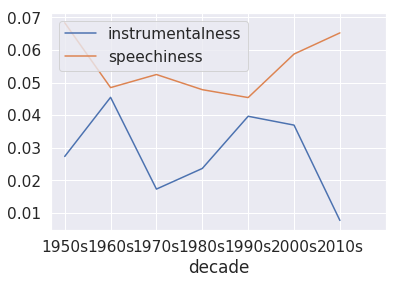

In [39]:
# This is comparing the instrumentalness to the liveness of the music, to see whether there appears to be an inverse 
# relation between the two

test = decades_data['instrumentalness'].groupby(decades_data['decade']).mean().to_frame()
test["liveness"] = decades_data['liveness'].groupby(decades_data['decade']).mean()
test["energy"] = decades_data['energy'].groupby(decades_data['decade']).mean()
test["popularity"] = decades_data['track.popularity'].groupby(decades_data['decade']).mean()
test["danceability"] = decades_data['danceability'].groupby(decades_data['decade']).mean()
test["speechiness"] = decades_data['speechiness'].groupby(decades_data['decade']).mean()
test['duration_ms'] = decades_data['duration_ms'].groupby(decades_data['decade']).mean()

test.plot.line(y=['instrumentalness', 'speechiness'])
plt.xticks([0,1,2,3,4,5,6, 7], test.index.values.tolist())
plt.show()

### Exploring The More Interesting Distributions 
#### Track Popularity 
The next image displays the popularity of each of the playlists. This does not represent the popularity of the songs during the corresponding decades but rather the popularity of them today. According to this link: https://www.statista.com/statistics/475821/spotify-users-age-usa/, about 55% of the current spotify users are between the ages of 18-34. This age group grew up with the music in the 80s, 90s, and 00s, so it makes sense that the more popular playlists are from those decades.

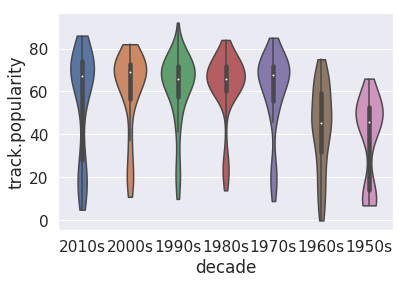

In [40]:
ax = sns.violinplot(x="decade", y="track.popularity", data=decades_data, cut = 0)

#### Energy Levels 
The following shows the distribution of energy levels of songs in each of the decades' playlists. As shown in the plot, the energy has increased from 1950 to the 2000s and 2010s.

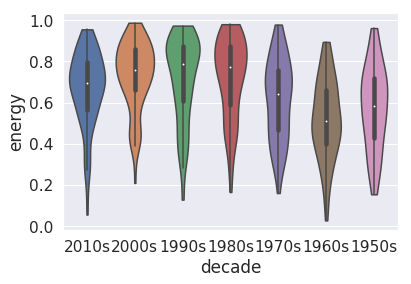

In [41]:
sns.violinplot(x="decade", y="energy", data=decades_data, cut = 0)

#### Loudness
The following shows the distribution of the loudness of each the songs in each of the decades' playlists. The closer the value is to 0 the quiter it is. So as shown in the plot, the loudness has been lower the last 2 decades cmopared to the 70s and 80s. This makes perfect sense because the 70s and 80s were the times of rock music, which tended to be very loud. These decades involved music genres such as punk rock, disco, hard rock, heavy metal, alternative rock etc. 

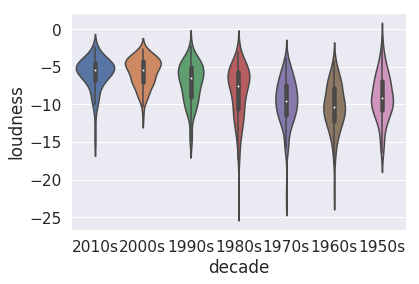

In [44]:
sns.violinplot(x="decade", y="loudness", data=decades_data)

#### Valence 
This plot displays the valence of the songs in the decades. Valence decribes the music positivevness of a song. As shown from the plot, the valence was much higher during the 1950s compared to today, which tends to range across the range of valence. This makes sense due the the tpes of genres during the 1950s such as rock and roll, doo-wop, pop, swing, which all tend to be very positive songs. Today, there is a range of music that can have different music positiveness depending on the subject the song is about.


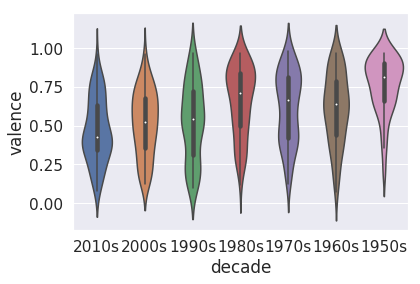

In [45]:
sns.violinplot(x="decade", y="valence", data=decades_data)


#### Danceability 
This plot displays the danceability of the songs. Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. It shows in the plot that the danceability of the songs during each deacde has been consistent throughout the last 7 decades.

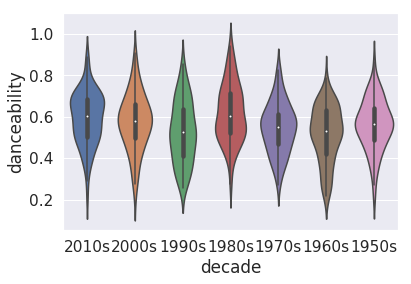

In [46]:
sns.violinplot(x="decade", y="danceability", data=decades_data)

#### Tempo 
This plot displays the tempo distribution in the songs for each decade playlist. The overall estimated tempo of a track in beats per minute (BPM). As expected, the 1950s has more songs that had a higher tempo, which is due to the high spirited genres of that time. After that decade, the distribution of the tempo in the playlist tend to be quite consistent.

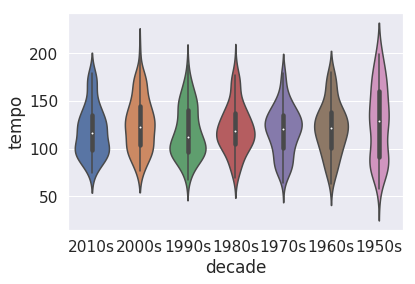

In [47]:
sns.violinplot(x="decade", y="tempo", data=decades_data)

#### Duration
This plot displays the duration in miliseconds of the songs for each decade. This plot shows that there were many more long songs during the 60s and 70s, which makes sense due to the type of music during the time(like Dark Side of the Moon! Come on!). There were more songs in the 60s and 70s that exceeded the normal average of 3-4 minutes long compared to today where there is rarely a song that exceeds 5 minutes.

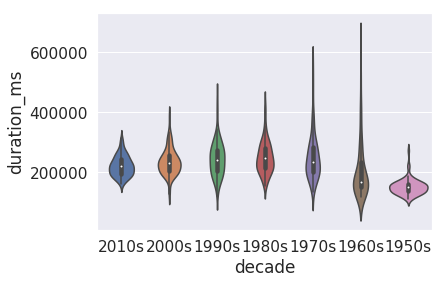

In [48]:
sns.violinplot(x="decade", y="duration_ms", data=decades_data)

#### Summary
Overall, the majority of trends of the audio features of the songs in each of the decades did match with what we were expecting. What did surprise us was the popularity of the 80s, 90s, and 00s playlists, because we assumed the 10s would be more popular due to it being the current decade. However, looking at the data on the age group of the Spotify users, it made sense as to why people would want to hear the songs they grew up with. The audio features of the songs in each of the decades' playlists related very much to the genres during the corresponding decade.

## Visualizing Song Lyrics through Genius and NLTK
We thought it would be interesting to compare across decades and see if there is a difference in the prevalence of certain words. To do so, we used the Genius API to be able to get the lyrics of every song in our decades_data dataframe. 

In [12]:
'''
    This method requests the URL of a song by querying by the song title and artist name
    Params: song_title -> string and artist_name -> string
    Returns: a string (either a song URL or an empty string if the song couldn't be found)
'''
def request_song_info(song_title, artist_name):
    # forming request
    base_url = 'https://api.genius.com'
    headers = {'Authorization': 'Bearer ' + genius_token}
    search_url = base_url + '/search'
    data = {'q': song_title.lower() + ' ' + artist_name.lower()}
    response = requests.get(search_url, data=data, headers=headers) # making the get request
    json = response.json()
    remote_song_info = None
    
    #Search resultls
    for hit in json['response']['hits']: #using the artist name to make sure we're actually getting the song we want
        if artist_name.lower() in hit['result']['primary_artist']['name'].lower():
            remote_song_info = hit
            break
        
    if remote_song_info: # returning song URL if matched
        song_url = remote_song_info['result']['url']
        return song_url
    else:
        return ""


#### Using NLTK 
It's not enough just to be able to get the lyrics of a song. If we want to get meaningful data, we will have to strip words like "the", "an", and "it". These are known as "stop words", and luckily, NTLK has a corpus of them. We can use NLTK to add a few stop-words that it doesn't pick up (like chorus, verse, nt, prechorus, and bridge). We can then filter these stop-words from the lyrics.

In [13]:
'''
    This method will return an array of the words within a song.
    Params: url -> string
    Returns: An array of words within the song
'''
def get_cleaned_lyrics(url):
    page = requests.get(url)
    html = BeautifulSoup(page.text, 'html.parser')
    lyrics = html.find('div', class_='lyrics').get_text()
    tokens = word_tokenize(lyrics) #Split the lyrics into an array of strings 
    # Some data-cleaning 
    tokens = [w.lower() for w in tokens] # convert them all to lowercase
    table = str.maketrans('', '', string.punctuation) # remove punctuation from each word
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]     # remove remaining tokens that are not alphabetic

    # filter out stop words
    stop_words = set(stopwords.words('english'))
    stop_words.add("chorus")
    stop_words.add("verse")
    stop_words.add("nt")
    stop_words.add("prechorus")
    stop_words.add("bridge")

    words = [w for w in words if not w in stop_words] #filter out the stop-words
    return stop_words, words


### Displaying The Results
Now that we have the lyrics, we can create meaningful (and pretty!) visualizations to compare the frequency of words across decades. We will use the Seaborn and Wordcloud modules to be able to do this!

#### Method Definitions

In [14]:
'''
    Generates a Word Cloud based on the frequency of words
    Param: freq -> Frequency object
    Return: Wordcloud object
'''
def generate_frequency_wordcloud(freq):
    wc = WordCloud()
    wc.generate_from_frequencies(freq)
    return wc

'''
    Displays a wordcloud 
    Param: wordcloud -> Wordcloud object, decade -> string
    Returns: Nothing, but displays a Wordcloud with the Decade string as the title
'''
def display_wordcloud(wordcloud, decade):
    plt.title(decade)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

'''
    Displays the frequency of a given dictionary of words in a bar-chart
    Params: freq -> dictionary, title -> string
    Returns: Nothing, but displays a bar chat with the given string as the title
'''
def display_barchart(freq, title):
    x_val = list(range(len(freq.keys())))
    fig, ax =  plt.subplots(figsize=(15,6))
    ax.set_title(title)
    sns.barplot(ax=ax, x=x_val, y=list(freq.values())).set(xticklabels=list(freq.keys()))
    plt.show()


In [15]:
'''
    Given an array of song titles and corresponding artist names, will return an array containing all of the lyrics
    for those songs
    Params: songs_arr -> list of strings, artist_arr -> list of strings
    Return: a list of all of the lyrics for every song found
'''
def decades_song(songs_arr, artist_arr):
    lyr = []
    for song, artist in zip(songs_arr, artist_arr):
        url = request_song_info(song, artist)
        #print("URL: "+url)
        if url is not "": 
            stop_words, lyrics = get_cleaned_lyrics(url)
            lyr += lyrics
           
    return stop_words, lyr


#### Actual Runnable Code

In [16]:
# decades_group = decades_data.groupby("decade") #grouping dataframe by decade
# decade_freq = {} # storing all frequencies into a dictionary
# for name, group in decades_group:
#     print("==========")
#     stop_words, lyr = decades_song(group["track.name"], group["name"])
#     decade_freq[name] = nltk.FreqDist(lyr) # storing frequency distribution in dictionary
#     display_wordcloud(generate_frequency_wordcloud(decade_freq[name]), name)
#     display_barchart(dict(decade_freq[name].most_common(30)), name)



### Making a Classifier
We wanted to see whether we could create an accurate classifier based off of the data we collected. We went into it with low expectations, and were unfortunately correct. As we'll explore below, the 2 classifiers we attempted had low accuracy, and by analyzing the data more carefully, it'll be easy to see why it's hard to create an accurate classifier

### Removing Unnecessary Features
I decided to remove features the "name" (which refered to the name of the artist) and "track.name" (which refered to the name of the song) because they have nothing to do with the decade of the song itself. I was worried that it may over-train based on the artist as well, and always guess that a song was from the 60s merely because it was by the Beatles, and not because of the qualities of the song in itself. Similarly, I removed the "added_at" column because it refers to when the track was added to the playlist, which has no bearing on when the song was made. I also removed "track.id" because it was duplicate column for the song ID, which was unnecessary to begin with. 

In [17]:
# Let's cut down the data to the features I think are relevant
ml_data = decades_data 
ml_data = ml_data.drop(columns = ["name", "added_at", "track.name", "track.id"])
cols = ml_data.columns.tolist()
cols = cols[6:7] + cols[:6] + cols[8:] #moving id to be the first column
ml_data = ml_data[cols]

### Deciding Which Models To Create
Figuring out the model to create was difficult for me. As someone without much machine-learning experience, it's overwhelming to try to find the best solution to your problem when you don't know what the potential options are. Luckily, the Internet had my back, and I found this awesome article: https://blog.statsbot.co/machine-learning-algorithms-183cc73197c which helped me to narrow down my search. I knew I wanted to do supervised learning of some sort, because I had labelled data, but realized quickly that I wanted algorithms optimized for multi-class classification (because I have multiple labels, one for each decade). 

I decided to try out both Random Forests and K-Nearest Neighbors because both seemed to fit well within the bounds of my problem. We felt that songs were similar within decades, so K-Nearest Neighbors fit well into that. Similarly, because we felt there would be distinguishing characteristics between decades, we thought the logic of a decision tree would work well. 

#### Random Forest 
To train the Random Forest model, I first one-hot encoded my labels, because my labels were categorical. Then, I split my data into training and testing sets. I scaled my features so that they would be standarized, and then fit a Random Forest Model to it. Lastly, I cross-validated it with a k = 10, and found the overall accuracy of the scores 

In [30]:
# One Hot Encoding
y_encoded = pd.get_dummies(ml_data["decade"])
features = ml_data.iloc[:, 1:-1]
features

#Splitting data
X_train, X_test, y_train, y_test = train_test_split(features, y_encoded, test_size = 0.25, random_state = 21)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)
#Cross Validating
scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring='accuracy')

# Predicting the Test Set Results
y_pred = classifier.predict(X_test)
print("Random Forest Classifier Score is " +str(classifier.score(X_test, y_test)))

0.113095238095


#### More Exploratory Data Analysis 
Because the accuracy of the random forest model was so low, I wanted to try and figure out why that was the case. I created a residual plot, correlation matrix, and confusion matrix to try and understand the model's low accuracy. Upon looking at the residuals, I noticed how frequently the model predicted incorrectly. The confusion matrix really illuminates that, revealing that the model seemed to frequently guess the 1950s. I also wanted to see if perhaps the data itself was muddied, and looking at the correlations, it seemed to be the case. There was no one predictor of the decade a song was created in, and in fact, many of the correlations were low (below 0.3). This leads me to believe that our dataset is not strong or varied enough for a classifier to work, but I decided to create one last model just to confirm my hypothesis.

In [31]:
'''
    Creates a residual plot 
    Params: y_pred -> list of floats, y_test -> list of floats, title -> string
    Returns: Nothing, but shows the residual p
'''
def residuals_plot(y_pred, y_test, title):
    fig, ax =  plt.subplots(figsize=(15,6))
    ax.set_title(title)
    ax.set(xlabel="Predicted Decade", ylabel="Actual Decade")
    sns.scatterplot(ax=ax, x=y_pred.argmax(axis=1), y= y_test.values.argmax(axis=1))
    plt.show()

'''
    Creates a graph of a confusion matrix. 
    Params: cm -> NP Array, classes -> list of strings, title -> string
    Returns: Nothing, but shows the confusion matrix
'''
def create_confusion_matrix(cm, classes, title):
    print(type(cm))
    plt.figure()
    sns.set(font_scale=1.4) #for label size
    heatmap = sns.heatmap(cm, annot=True, annot_kws={"size": 16})# font size
    fontsize = 16
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.set(xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

'''
    Creates a graph of a correlation matrix. 
    Params: cm -> NP Array, title -> string
    Returns: Nothing, but shows the correlation matrix
'''
def create_correlation_matrix(cm, title):
    plt.figure()
    fig, ax =  plt.subplots(figsize=(10,8))
    ax.set_title(title)
    sns.heatmap(corr, ax = ax,  xticklabels=cm.columns.values,yticklabels=cm.columns.values)
    plt.show()


In [ ]:
cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
create_confusion_matrix(cm, classes, "Confusion Matrix for Random Forest")
corr_data = pd.concat([ml_data, y_encoded], axis = 1)
corr = corr_data.corr()
create_correlation_matrix(corr, "Correlation Matrix for Decades Data")
residuals_plot(y_pred, y_test, "Residuals for KNN")

#### K- Nearest Neighbors
Following this tutorial: https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/, I pretty much did the same thing for the Random Forest as I did for the KNN. I trained the data and saw the score, and decided to create a graph to see at which value of k the model performed the best. I did this by trying neighbors between 1-50, and graphing how often the model mis-classified a point. This was largely based off of the tutorial, but I found it to be a helpful way of determining the best value of k, which I had arbitrarily determined to be 7 initially.

Accuracy of KNN is: 0.154761904762
<class 'numpy.ndarray'>
The optimal number of neighbors is 1


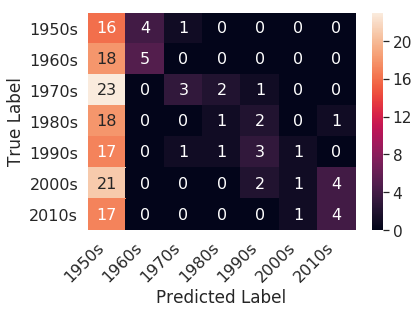

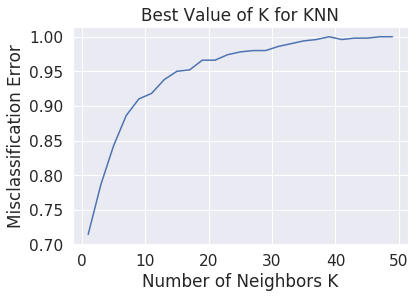

In [37]:
# training a KNN classifier 
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train) 
accuracy = knn.score(X_test, y_test) 
print ("Accuracy of KNN is: " +str(accuracy))

# creating a confusion matrix 
knn_predictions = knn.predict(X_test)
create_confusion_matrix(confusion_matrix(y_test.values.argmax(axis=1), knn_predictions.argmax(axis=1)), classes, "Confusion Matrix of KNN")

# creating odd list of K for KNN
myList = list(range(1,50))

# filtering just the odd ones
neighbors = filter(lambda x: x % 2 != 0, myList)

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print ("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.figure()
plt.title("Best Value of K for KNN")
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


### Discussion
In both cases, I found the accuracy to be too low, leading me to believe that there is likely something wrong within the data. Our dataset is pretty small, with only around a 100 songs maximum per decade. Perhaps there is no real trend at all between decades of music, and to see real differences, we would need to look in chunks of 20, 30, or even 40 years. This is pretty likely too. Regardless, this was our personal exploration into data science through the thing we all know and love, and had an interesting time doing it too!